<a href="https://colab.research.google.com/github/Data-Creater-Atlas/Data-Atlas/blob/Seongjong/mission1_0912.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# 1 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 2 데이터 루트 지정
import os
from pathlib import Path

# 실제 파일들이 있는 Google Drive 경로로 DATA_ROOT를 설정합니다.
from pathlib import Path

# 경로를 Path 객체로 만듭니다.
DATA_ROOT = Path("/content/drive/MyDrive/Data Camp/53.대기오염 배출원 공간 분포 데이터/3.개방데이터/1.데이터")
# 경로가 존재하는지 확인
if not Path(DATA_ROOT).exists():
    print(f"경로를 찾을 수 없습니다: {DATA_ROOT}")
else:
    print("성공적으로 DATA_ROOT를 설정했습니다.")
    print("DATA_ROOT : ", DATA_ROOT)

성공적으로 DATA_ROOT를 설정했습니다.
DATA_ROOT :  /content/drive/MyDrive/Data Camp/53.대기오염 배출원 공간 분포 데이터/3.개방데이터/1.데이터


In [4]:
# 3 라이브러리 설치

!pip install ultralytics matplotlib -q

In [5]:
# 3 학습 및 테스트 파일 경로 / 폴더 지정
from pathlib import Path

# 원본 데이터( 이미지 / 라벨 JSON ) - 드라이브 경로 기준
TS_DIR = DATA_ROOT / "Training" / "01.원천데이터" / "TS_KS"
TL_JSON_DIR = DATA_ROOT / "Training" / "02.라벨링데이터" / "TL_KS_BBOX"
VS_DIR = DATA_ROOT / "Validation" / "01.원천데이터" / "VS_KS"
VL_JSON_DIR = DATA_ROOT / "Validation" / "02.라벨링데이터" / "VL_KS_BBOX"

# YOLO 데이터셋 출력 위치 - 드라이브 경로 기준
DATASET_DIR = DATA_ROOT / "YOLO_Dataset"
(TR_IMG_DIR := DATASET_DIR/"train/images").mkdir(parents=True, exist_ok=True)
(TR_LABEL_DIR := DATASET_DIR/"train/labels").mkdir(parents=True, exist_ok=True)
(VAL_IMG_DIR := DATASET_DIR/"valid/images").mkdir(parents=True, exist_ok=True)
(VAL_LABEL_DIR := DATASET_DIR/"valid/labels").mkdir(parents=True, exist_ok=True)

CLASS_NAMES = ["chimney"]

In [6]:
# 4 VIA JSON 라벨 -> YOLO 포맷 변환 및 이미지 복사
import json
import shutil
from tqdm import tqdm

def _ensure_float(v):
    return float(str(v).strip())

def via_json_to_yolo(json_path: Path, images_dir: Path, out_img_dir: Path, out_lbl_dir: Path, class_id: int = 0):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    for key, item in data.items():
        img_name = item.get("filename") or key
        if "." in img_name:
            stem, ext = img_name.rsplit(".", 1)
            img_name = stem + "." + ext

        src_img = images_dir / img_name
        if not src_img.exists():
            cands = list(images_dir.glob(Path(img_name).stem + ".*"))
            if cands:
                src_img = cands[0]
            else:
                continue

        fa = item.get("file_attributes", {})
        W = int(_ensure_float(fa.get("img_width", 0)))
        H = int(_ensure_float(fa.get("img_height", 0)))
        if W == 0 or H == 0:
            continue

        lines = []
        for region in item.get("regions", []):
            sa = region.get("shape_attributes", {})
            name = sa.get("name", "")
            if name == "rect":
                x, y = _ensure_float(sa["x"]), _ensure_float(sa["y"])
                bw, bh = _ensure_float(sa["width"]), _ensure_float(sa["height"])
            elif name == "polyline":
                xs, ys = sa.get("all_points_x", []), sa.get("all_points_y", [])
                if not xs or not ys: continue
                min_x, max_x = min(xs), max(xs)
                min_y, max_y = min(ys), max(ys)
                x, y = _ensure_float(min_x), _ensure_float(min_y)
                bw, bh = _ensure_float(max_x - min_x), _ensure_float(max_y - min_y)
            else:
                continue

            cx = max(0, min(1, (x + bw/2) / W))
            cy = max(0, min(1, (y + bh/2) / H))
            nw = max(0, min(1, bw / W))
            nh = max(0, min(1, bh / H))
            if nw <= 0 or nh <= 0:
                continue
            lines.append(f"{class_id} {cx:.6f} {cy:.6f} {nw:.6f} {nh:.6f}")

        if lines:
            out_lbl = out_lbl_dir / f"{Path(img_name).stem}.txt"
            out_lbl.write_text("\n".join(lines), encoding="utf-8")
            dst_img = out_img_dir / src_img.name
            if not dst_img.exists():
                shutil.copy2(src_img, dst_img)

print("학습용 데이터 변환 중...")
for jp in tqdm(sorted(TL_JSON_DIR.glob("*.json")), desc="Train JSON -> YOLO"):
    via_json_to_yolo(jp, TS_DIR, TR_IMG_DIR, TR_LABEL_DIR, class_id=0)

print("검증용 데이터 변환 중...")
for jp in tqdm(sorted(VL_JSON_DIR.glob("*.json")), desc="Validation JSON -> YOLO"):
    via_json_to_yolo(jp, VS_DIR, VAL_IMG_DIR, VAL_LABEL_DIR, class_id=0)

print("\n변환 완료!")
print("Train images:", len(list(TR_IMG_DIR.glob("*"))))
print("Train labels:", len(list(TR_LABEL_DIR.glob("*.txt"))))
print("Validation images:", len(list(VAL_IMG_DIR.glob("*"))))
print("Validation labels:", len(list(VAL_LABEL_DIR.glob("*.txt"))))

학습용 데이터 변환 중...


Train JSON -> YOLO: 100%|██████████| 8052/8052 [35:42<00:00,  3.76it/s]


검증용 데이터 변환 중...


Validation JSON -> YOLO: 100%|██████████| 1006/1006 [04:44<00:00,  3.54it/s]



변환 완료!
Train images: 8052
Train labels: 8052
Validation images: 1006
Validation labels: 1006


In [7]:
# 5 yaml 파일 생성
data_yaml = f"""
train: {str(TR_IMG_DIR)}
val: {str(VAL_IMG_DIR)}

nc: {len(CLASS_NAMES)}
names: {CLASS_NAMES}
""".strip()

(DATASET_DIR / "data.yaml").write_text(data_yaml, encoding="utf-8")
print("data.yaml 파일 내용:")
print((DATASET_DIR / "data.yaml").read_text())

data.yaml 파일 내용:
train: /content/drive/MyDrive/Data Camp/53.대기오염 배출원 공간 분포 데이터/3.개방데이터/1.데이터/YOLO_Dataset/train/images
val: /content/drive/MyDrive/Data Camp/53.대기오염 배출원 공간 분포 데이터/3.개방데이터/1.데이터/YOLO_Dataset/valid/images

nc: 1
names: ['chimney']


In [8]:
# 6 yolo 학습
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

results = model.train(
    data=str(DATASET_DIR / "data.yaml"),
    epochs=60,
    imgsz=512,
    batch=16,
    patience=20,
    project=str(DATA_ROOT / "yolo_training_runs"),
    name="direct_drive_512px_50e", # 실험 이름
    verbose=True,
    cache=True # 데이터 로딩 속도 개선을 위해 캐시 옵션을 활성화합니다.
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.199 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Data Camp/53.대기오염 배출원 공간 분포 데이터/3.개방데이터/1.데이터/YOLO_Dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015,

결과 파일 경로: /content/drive/MyDrive/Data Camp/53.대기오염 배출원 공간 분포 데이터/3.개방데이터/1.데이터/yolo_training_runs/direct_drive_512px_50e/results.csv


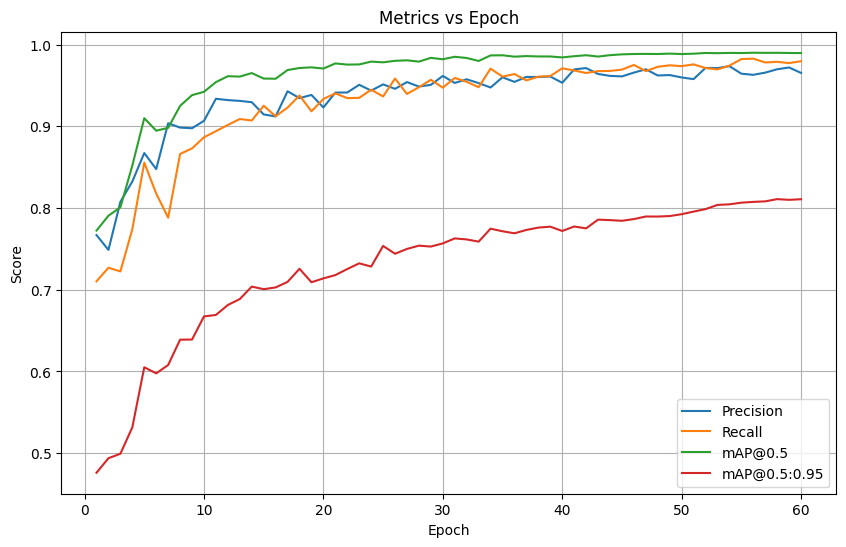

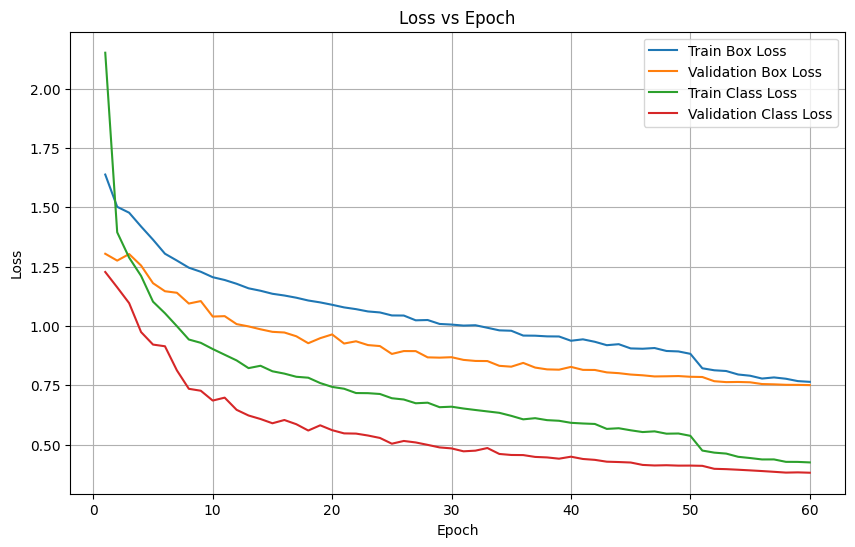

In [9]:
# 7. 평가 지표 시각화 및 출력
import pandas as pd
import matplotlib.pyplot as plt

# 학습 결과가 저장된 경로
results_path = Path(DATA_ROOT) / "yolo_training_runs" / "direct_drive_512px_50e" / "results.csv"

assert results_path.exists(), f"결과 파일을 찾을 수 없습니다: {results_path}"
print(f"결과 파일 경로: {results_path}")

df = pd.read_csv(results_path)
df.columns = df.columns.str.strip()
epoch = df.index + 1

# 정밀도, 재현율, mAP 그래프
plt.figure(figsize=(10, 6))
plt.plot(epoch, df['metrics/precision(B)'], label='Precision')
plt.plot(epoch, df['metrics/recall(B)'],  label='Recall')
plt.plot(epoch, df['metrics/mAP50(B)'],    label='mAP@0.5')
plt.plot(epoch, df['metrics/mAP50-95(B)'],  label='mAP@0.5:0.95')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Metrics vs Epoch")
plt.grid(True)
plt.legend()
plt.show()

# 손실(Loss) 그래프
plt.figure(figsize=(10, 6))
plt.plot(epoch, df['train/box_loss'], label='Train Box Loss')
plt.plot(epoch, df['val/box_loss'], label='Validation Box Loss')
plt.plot(epoch, df['train/cls_loss'], label='Train Class Loss')
plt.plot(epoch, df['val/cls_loss'], label='Validation Class Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.grid(True)
plt.legend()
plt.show()

In [10]:
#8. 최종 성능 지표 출력
# 'best.pt' 가중치를 사용해 최종 성능 검증
results = model.val(data=str(DATASET_DIR/"data.yaml"), imgsz=512, split="val")

# 결과 사전에서 성능 지표 추출
precision = results.results_dict.get('metrics/precision(B)', 0)
recall = results.results_dict.get('metrics/recall(B)', 0)
map50 = results.results_dict.get('metrics/mAP50(B)', 0)
map50_95 = results.results_dict.get('metrics/mAP50-95(B)', 0)


print("---" * 15)
print("🚀 최종 모델 성능 지표 (best.pt 기준)")
print("---" * 15)
print(f"  - Precision (정밀도)      : {precision:.4f}")
print(f"  - Recall (재현율)         : {recall:.4f}")
print(f"  - mAP@.5 (미션 평가 지표) : {map50:.4f}")
print(f"  - mAP@.5:.95             : {map50_95:.4f}")
print("---" * 15)

Ultralytics 8.3.199 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 62.9±18.0 MB/s, size: 104.6 KB)
val: Scanning /content/drive/MyDrive/Data Camp/53.대기오염 배출원 공간 분포 데이터/3.개방데이터/1.데이터/YOLO_Dataset/valid/labels.cache... 1006 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1006/1006 1.4Mit/s 0.0s
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.
val: Caching images (0.7GB RAM): 100% ━━━━━━━━━━━━ 1006/1006 442.3it/s 2.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 63/63 10.5it/s 6.0s
                   all       1006       1322       0.97      0.979       0.99       0.81
Speed: 0.3ms preprocess, 2.6ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /content/driv